# A Convolutional neural network (CNN) for the MNIST dataset using PyTorch


## Import libraries

In [1]:
import torch
from torchvision import datasets, transforms

from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data.sampler import SubsetRandomSampler, RandomSampler
import torch.utils.data.dataloader as dataloader

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
from sklearn.model_selection import train_test_split

### Check for GPU

In [2]:
if torch.cuda.is_available():
    device = "cuda"
    print("device=",device)

device= cuda


## Load data and define augmentation

In [3]:
transform = transforms.Compose([
    #transforms.CenterCrop(244),
    #transforms.RandomHorizontalFlip(p = 0.2),
    transforms.RandomRotation(20),
    transforms.ToTensor()
    #transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])

train_data = datasets.MNIST('data', train=True,transform = transform, download = True)
test_data = datasets.MNIST('data', train = False,transform = transform, download = True  )

In [4]:
len(train_data), len(test_data), (train_data.train_labels)

(60000, 10000, tensor([5, 0, 4,  ..., 5, 6, 8]))

## Create validation set and data iterator

In [5]:
batch_size = 20

validation_size = 0.2
num_workers = 0
train_size = int(len(train_data) *(1- validation_size))
val_size = int(len(train_data)*validation_size)
#print(train_size, val_size)
train_indices = np.arange(len(train_data))
np.random.shuffle(train_indices)

split = int(np.floor(validation_size * len(train_data)))
print(train_size, val_size, len(train_indices), split)
train_idx, val_idx = train_indices[split:], train_indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx)


train_loader = torch.utils.data.DataLoader(train_data,batch_size = batch_size, 
                                           sampler = train_sampler,num_workers = num_workers                                          
                                          )

val_loader = torch.utils.data.DataLoader(train_data,batch_size = batch_size, 
                                           sampler = val_sampler,num_workers = num_workers                                          
                                          )

test_loader = torch.utils.data.DataLoader(test_data,batch_size = batch_size, 
                                           num_workers = num_workers                                          
                                          )

48000 12000 60000 12000


## Visualize one set of training data

In [6]:
images, label = next(iter(train_loader))
images = images.numpy()

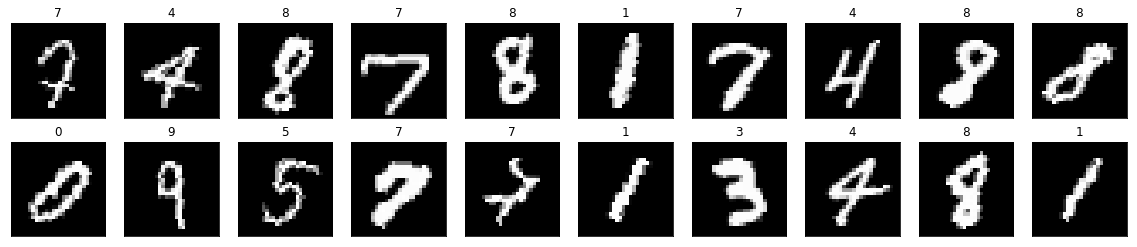

In [7]:
images[0], label[0]

#print(images[0].shape, label[0])

fig,ax = plt.subplots(2, 10, figsize = (20,4))
for i in range(batch_size):
#     print(i,int(i/10))
    a = ax[int(i/10),i%10]
    a.imshow(images[i].squeeze(), cmap = 'gray')
    a.set_title(label[i].item())
    a.set_xticks([])
    a.set_yticks([])
#     ax.show()

In [146]:
images, label = next(iter(train_loader))
images[0].shape, images[0].view(-1,28*28).shape

(torch.Size([1, 28, 28]), torch.Size([1, 784]))

## Define network architecture

* 2 convolutional layers with max pooling
* 2 fully connected layers
* Activation - RelU
* Dropout = 30%
* Model trained on GPU
* Model output - Log Softmax

In [36]:
in_size = 28*28

class Net(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 8, kernel_size = 3, padding = 1)
        self.conv2 = nn.Conv2d(in_channels = 8, out_channels = 32, kernel_size = 3, padding = 1)
        self.pool = nn.MaxPool2d(kernel_size = 2, stride = 2)
        
        self.fc1 = nn.Linear(in_features = 32*7*7, out_features = 512)
        self.fc2 = nn.Linear(in_features = 512, out_features = 10)
        self.dropout = nn.Dropout(p = 0.3)
        
    def forward(self,x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1,32*7*7)
        x = self.dropout(F.relu(self.fc1(x)))
        x = F.log_softmax(self.fc2(x),dim = 1)
        return x

model = Net()
model.cuda()

Net(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(8, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1568, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
  (dropout): Dropout(p=0.3)
)

## Defining loss and optimizer


* Loss criterion - Negative Log Likelihood Loss
* Optimizer - Adam

In [37]:
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001, weight_decay = 0.0001 )

## Training and validation Step
* Epochs - 20
* Saving model if validation loss goes down

In [38]:
%%time
epochs = 10

running_train_loss = []
running_val_loss = []

v_loss_min = np.Inf
# accuracy = 0

for epoch in range(1,epochs+1):
    model.train()
    t_loss = 0
    v_loss = 0
    accuracy = 0
    
    for images, labels in train_loader:
        images, labels = images.cuda(), labels.cuda()
        
        optimizer.zero_grad()
        
        train_output = model(images)
        
        train_loss = criterion(train_output, labels)
        
        train_loss.backward()
        
        optimizer.step()
        
        t_loss += train_loss.item()
    
    with torch.no_grad():
        model.eval()
        
        for images, labels in val_loader:
            
            images, labels = images.cuda(), labels.cuda()

            val_output = model(images)
            
            val_loss = criterion(val_output, labels)
            v_loss += val_loss.item()
            
            _,pred_classes = torch.max(val_output,dim = 1)
            eq = pred_classes == labels #.view(*pred_classes.shape)
            accuracy += torch.mean(eq.type(torch.FloatTensor))
            
    
    t_loss = t_loss/(len(train_loader))
    v_loss = v_loss/(len(val_loader))
    
    running_train_loss.append(t_loss)
    running_val_loss.append(v_loss)
    
    
    print("Epoch {}\t..training loss: {:.5f}\t..validation_loss:{:.5f}\t..val accuracy:{:.3f}%".format(epoch,
                                                                                                  t_loss,
                                                                                                  v_loss,
                                                                                                 100*(accuracy.item()/len(val_loader))))
    
    print("Raw Accuracy:", accuracy.item())
    if v_loss <= v_loss_min:
        print("validation loss decreased from {:.5f} to {:.5f}..saving moodel\n".format(v_loss_min, v_loss))
        torch.save(model.state_dict(),'mnist_cnn_as.pt')
        v_loss_min = v_loss
    else:
        print("validation loss increased from {:.5f} to {:.5f}\n".format(v_loss_min, v_loss))
                 

Epoch 1	..training loss: 0.24147	..validation_loss:0.09787	..val accuracy:96.975%
Raw Accuracy: 581.8511962890625
validation loss decreased from inf to 0.09787..saving moodel

Epoch 2	..training loss: 0.10569	..validation_loss:0.09222	..val accuracy:97.267%
Raw Accuracy: 583.6010131835938
validation loss decreased from 0.09787 to 0.09222..saving moodel

Epoch 3	..training loss: 0.08505	..validation_loss:0.07175	..val accuracy:97.767%
Raw Accuracy: 586.6011962890625
validation loss decreased from 0.09222 to 0.07175..saving moodel

Epoch 4	..training loss: 0.07270	..validation_loss:0.06881	..val accuracy:97.808%
Raw Accuracy: 586.8509521484375
validation loss decreased from 0.07175 to 0.06881..saving moodel

Epoch 5	..training loss: 0.06526	..validation_loss:0.05725	..val accuracy:98.333%
Raw Accuracy: 590.0009155273438
validation loss decreased from 0.06881 to 0.05725..saving moodel

Epoch 6	..training loss: 0.06353	..validation_loss:0.06139	..val accuracy:98.033%
Raw Accuracy: 588.2008

### Checking running train and validation loss

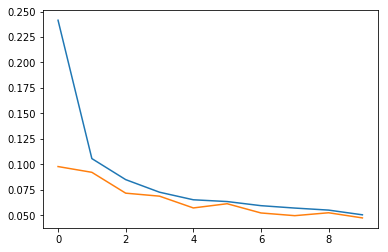

In [122]:
plt.plot(running_train_loss, label='Training loss')
plt.plot(running_val_loss, label='Validation loss')
# plt.legend(frameon=False)
plt.show()

### Load saved model

In [39]:
model.load_state_dict(torch.load('mnist_cnn_as.pt'))

In [123]:
print(pred_classes,labels, pred_classes.shape, labels.shape)
e = pred_classes == labels
print(e, torch.mean(e.type(torch.FloatTensor)))

tensor([8, 4, 2, 1, 7, 4, 2, 7, 6, 6, 6, 6, 3, 7, 3, 1, 5, 2, 2, 3],
       device='cuda:0') tensor([2, 6, 5, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6],
       device='cuda:0') torch.Size([20]) torch.Size([20])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       device='cuda:0', dtype=torch.uint8) tensor(0.0500)


In [43]:
len(train_data), len(train_loader), len(train_loader.dataset), len(val_loader), len(val_loader.dataset), val_loader.batch_size

(60000, 2400, 60000, 600, 60000, 20)

In [125]:
model.eval()
o = model(images)
print(o[0])
o1 = torch.exp(o)
a,b = torch.max(o,dim = 1)
print(o.shape,b)
print(labels)
print(b.shape,labels.shape)

tensor([-1.3682e+01, -9.3901e+00, -1.0742e+01, -1.0839e+01, -7.2895e+00,
        -5.3614e+00, -6.2500e+00, -1.2217e+01, -7.4668e-03, -1.3871e+01],
       device='cuda:0', grad_fn=<SelectBackward>)
torch.Size([20, 10]) tensor([8, 4, 2, 1, 7, 4, 2, 7, 6, 6, 6, 6, 3, 7, 3, 1, 5, 2, 2, 3],
       device='cuda:0')
tensor([2, 6, 5, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6],
       device='cuda:0')
torch.Size([20]) torch.Size([20])


In [48]:
a,b = torch.max(o,dim = 1)
print(o.shape,b)
print(labels)
print(b.shape,labels.shape)

torch.Size([20, 10]) tensor([8, 4, 2, 1, 7, 4, 2, 7, 6, 6, 6, 6, 3, 7, 3, 1, 5, 2, 2, 3],
       device='cuda:0')
tensor([8, 4, 8, 1, 7, 4, 2, 7, 6, 6, 6, 6, 3, 7, 3, 1, 5, 2, 2, 3],
       device='cuda:0')
torch.Size([20]) torch.Size([20])


In [49]:
model(images)[0], torch.exp(model(images)[0])

(tensor([-1.3682e+01, -9.3901e+00, -1.0742e+01, -1.0839e+01, -7.2895e+00,
         -5.3614e+00, -6.2500e+00, -1.2217e+01, -7.4668e-03, -1.3871e+01],
        device='cuda:0', grad_fn=<SelectBackward>),
 tensor([1.1427e-06, 8.3544e-05, 2.1622e-05, 1.9626e-05, 6.8269e-04, 4.6942e-03,
         1.9305e-03, 4.9470e-06, 9.9256e-01, 9.4610e-07], device='cuda:0',
        grad_fn=<ExpBackward>))

In [126]:
x = b == labels
x
torch.mean(x.type(torch.FloatTensor))

tensor(0.0500)

## Check on test set

In [64]:
class_correct = [0. for x in range(10)]
class_totals = [0. for x in range(10)]

with torch.no_grad():

    model.eval()
    for data, labels in test_loader:
        data, labels = data.cuda(), labels.cuda()
        log_ps = model(data)
        test_output = torch.exp(log_ps)
        _,class_pred = torch.max(test_output, dim = 1)
#         class_pred = class_pred.cpu()
#         labels = labels.cpu()
        labels[i]
        
        for i in range(batch_size):
            #print(class_pred[i])
            label = labels[i].item()
            if class_pred[i].item() == label:
                class_correct[label] += 1
            class_totals[label] += 1
            #print(label, class_pred[i].item())

for i in range(10):
    print("Accuracy of class {}: {}%".format(i,100*class_correct[i]/class_totals[i]))

total_correct = np.sum(class_correct)
total = np.sum(class_totals)
print("\nTotal Accuracy = {:.2f}%".format(100* total_correct/total)) 
print("total correct {} out of {}".format(total_correct,total))    

Accuracy of class 0: 99.79591836734694%
Accuracy of class 1: 99.29515418502203%
Accuracy of class 2: 97.86821705426357%
Accuracy of class 3: 99.5049504950495%
Accuracy of class 4: 99.08350305498982%
Accuracy of class 5: 97.86995515695067%
Accuracy of class 6: 98.95615866388309%
Accuracy of class 7: 98.5408560311284%
Accuracy of class 8: 98.35728952772074%
Accuracy of class 9: 96.92765113974232%

Total Accuracy = 98.63%
total correct 9863.0 out of 10000.0


In [101]:
test,label = next(iter(train_loader))
test,label = test.cuda(), label.cuda()

In [102]:
test.shape, test[0].shape

(torch.Size([20, 1, 28, 28]), torch.Size([1, 28, 28]))

In [103]:
test[0].view(1,1,28,28).shape

torch.Size([1, 1, 28, 28])

In [104]:
model(test[0].view(1,1,28,28))

tensor([[-1.2707e+01, -4.5347e-04, -1.2792e+01, -1.6130e+01, -1.1767e+01,
         -1.3603e+01, -1.0629e+01, -1.0870e+01, -7.8379e+00, -1.4194e+01]],
       device='cuda:0', grad_fn=<LogSoftmaxBackward>)

### Checking output on one image

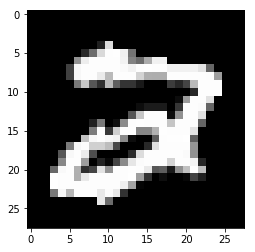

In [127]:
with torch.no_grad():
    test_image = test[0].view(1,1,28,28)
    output = torch.exp(model(test_image))
_,output_test = torch.max(output,1)
output_test, label[0]
im = np.squeeze(data[0].cpu().numpy())
im.shape
plt.imshow(im, cmap = 'gray')

### Visualizing output on one batch of test data

In [117]:
with torch.no_grad():
    output_model = torch.exp(model(data))
    _,output_label = torch.max(output_model, 1)
output_label = output_label.cpu().numpy()

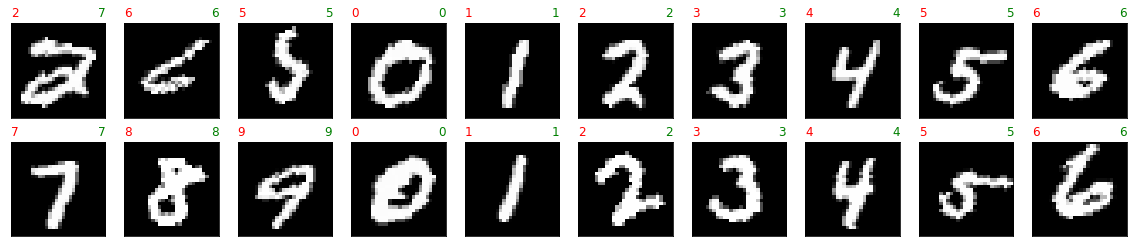

In [121]:
#print(images[0].shape, label[0])

fig,ax = plt.subplots(2, 10, figsize = (20,4))
for i in range(batch_size):
#     print(i,int(i/10))
    a = ax[int(i/10),i%10]
    a.imshow(data[i].cpu().squeeze(), cmap = 'gray')
    a.set_title(labels[i].cpu().item(), loc = 'left', color = 'red')
    a.set_title(output_label[i], loc = 'right', color = 'green')
    a.set_xticks([])
    a.set_yticks([])

## End